<h3>In-Depth Analysis</h3>
<p>In this section of our report, we will be looking at the different machine learning algorithms needed for our capstone project. As we have already explored the data quite extensively through our data wrangling and exploratory analysis, it is time to put our results from this to work!</p>

<p>As we are trying to predict out a continuous variable (points scored), we will be focusing in on two different machine learning algorithms:<br>
- Linear Regression<br>
- Random Forest Regressor</p>

<p>I will be splitting this section into the following parts:<br>
1. Final Data Cleaning/Data Wrangling (Removing future variable biases)<br>
2. Fitting our data into the Linear Regression Model<br>
3. Analyzing our Linear Regression Results<br>
4. Fitting our data into the Random Forest Regressor Model<br>
5. Cross Validate our Random Forest Regressor and optimize<br>
6. Compare our Linear Regression Model with the Random Forest Regressor<br>
7. Compare our optimal machine learning algorithm with the Y-T-D average<br>
8. Conclusion and Next Steps</p>

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nba_py.player import PlayerSummary
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None  # default='warn'

<h3>1. Final Data Cleaning/Data Wrangling (Removing future variable biases)</h3>
<p>We've done a lot of data cleaning in our data wrangling section. We've also done a lot of data cleaning to find the data points that are highly correlated with points:<br>
- Categorical Data: Starter or Not, Player Position, Team playing against, Home vs Away, Game Number<br>
- Statistical Data: MIN, FG2M, FG2A, FG3M, FG3A, FTM, FTA</p>
<p>We require two final data cleaning stages before we can assume we can complete our first data analysis:<br>
1. We must create year-to-date average and past three game averages for the statistical categories that we will be using.
2. We must also create our dependent variables and our independent variables to fit into our dataset.
</p>

<p>We must create last game's score, year-to-date averages and past three game averages because currently, each collection in our dataset represents what is happening within that exact game. If we were to use the statistical data in each collection to predict out points, it would be like using future variables to predict out points. This would obviously be a bias and there would be a linear way in doing this as well by summing the FG2M, FG3M and FTA together with respective coefficients.</p>
<p>Of course, we can also use different moving averages (weekly moving average, monthly moving average, etc.). However, we want our machine learning algorithm to work as soon as possible. If we were to use a large window period for our moving average, we may potentially have to wait as we will have NaN values. For simplicity, we will stick with using the last game's score, year-to-date averages and past three games.</p>

<p>Note that in the below function, we are returning a learning set and an observation set. Our "learning set" is meant to be the data that we will be traing our Machine Learning Algorithms on. While the "observation set" will be used for plotting graphs to see if there are any particular areas that our machine learning model is weak at predicting.</p>

<p>The reason we are creating two right now is because machine learning algorithms require dummy variables which results in more columns and more lines of code. By creating our observation set, it will be much easier to graph and see where our machine learning model is weak at predicting.</p>

In [2]:
train_years = ['2014-15','2015-16','2016-17']
test_years = ['2017-18']
def data_cleaning(seasons):
    df = pd.DataFrame()
    for year in seasons:
        temp_df = pd.read_csv("../raw_data/eda_data"+year+".csv")
        df = pd.concat([df, temp_df])
    df= df.drop(['FT_PCT'], axis=1)
    #NOTE - we have some players who do not have a position assigned.
    #We are hanging on the API call to get these positions. For purposes of setting up the code, we'll drop these players.
    df = df.dropna(thresh=3)
    df = df[(df['CENTER'] == 'C') | (df['FORWARD'] == 'F') | (df['GUARD'] == 'G')]
    df = df.replace({'CENTER': 'C', 'FORWARD': 'F', 'GUARD':'G'}, 1)
    df = df.fillna(0)
    df['HOME_AWAY'] = np.where(df.MATCHUP.str.contains("@"), "AWAY","HOME")
    clean_df = df[['TEAM_ABBREVIATION', 'GAME_ID','GAME_NUMBER','HOME_AWAY', 'PLAYER_ID','CENTER', 'GUARD', 'STARTER','MIN', 'FG2M','FG2A','FG3M', 'FG3A', 'FTM', 'FTA','PTS' ]]
    clean_df['MIN_LASTGAME'] = clean_df.MIN.shift(1)
    clean_df['FG2M_LASTGAME'] = clean_df.FG2M.shift(1)
    clean_df['FG2A_LASTGAME'] = clean_df.FG2A.shift(1)
    clean_df['FG3M_LASTGAME']= clean_df.FG3M.shift(1)
    clean_df['FG3A_LASTGAME']= clean_df.FG3A.shift(1)
    clean_df['FTM_LASTGAME']= clean_df.FTM.shift(1)
    clean_df['FTA_LASTGAME']= clean_df.FTA.shift(1)
    lis = ['PTS','MIN','FG2M','FG2A','FG3M', 'FG3A', 'FTM', 'FTA']
    lis_modified = [item + '_AVGLAST3GAMES' for item in lis]
    dictionary = dict(zip(lis, lis_modified))
    lis_YTD= [item + '_YTD' for item in lis]
    YTD = dict(zip(lis, lis_YTD))

    player_games_grouped = clean_df.set_index(['GAME_ID']).groupby(['PLAYER_ID'])
    player_games_threegame = pd.DataFrame(player_games_grouped.rolling(center=False,window=3,win_type='triang')['PTS','MIN','FG2M','FG2A','FG3M', 'FG3A', 'FTM', 'FTA'].mean().shift()).rename(index=str, columns=dictionary).reset_index()
    players_games_ytd = player_games_grouped['PTS','MIN','FG2M','FG2A','FG3M', 'FG3A', 'FTM', 'FTA'].expanding(min_periods=2).mean().rename(index=str, columns=YTD).reset_index()
    player_games = clean_df[['PTS','PLAYER_ID','GAME_ID','HOME_AWAY','GAME_NUMBER','CENTER','GUARD', 'STARTER','MIN_LASTGAME', 'FG2M_LASTGAME','FG2A_LASTGAME','FG3M_LASTGAME', 'FG3A_LASTGAME','FTM_LASTGAME','FTA_LASTGAME']]
    training_set = pd.merge(player_games_threegame, players_games_ytd, left_on=['PLAYER_ID', 'GAME_ID'], right_on=['PLAYER_ID','GAME_ID'])
    training_set['GAME_ID'] = training_set['GAME_ID'].apply(int)
    training_set['PLAYER_ID'] = training_set['PLAYER_ID'].apply(int)
    second_set = pd.merge(player_games, training_set, left_on=['PLAYER_ID', 'GAME_ID'], right_on=['PLAYER_ID','GAME_ID'])
    observation_set = second_set.drop(['PLAYER_ID', 'GAME_ID'], axis=1)
    learning_set = pd.get_dummies(observation_set, drop_first=True)
    learning_set = pd.get_dummies(learning_set, columns=['GAME_NUMBER'], drop_first=True)
    learning_set = learning_set.dropna()
    observation_set = observation_set.dropna()
    return learning_set, observation_set

In [3]:
train_set, observation_train = data_cleaning(train_years)
test_set, observation_test = data_cleaning(test_years)
train_set.head()

C:\Users\Boris-Tsao\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,PTS,CENTER,GUARD,MIN_LASTGAME,FG2M_LASTGAME,FG2A_LASTGAME,FG3M_LASTGAME,FG3A_LASTGAME,FTM_LASTGAME,FTA_LASTGAME,...,GAME_NUMBER_72,GAME_NUMBER_73,GAME_NUMBER_74,GAME_NUMBER_75,GAME_NUMBER_76,GAME_NUMBER_77,GAME_NUMBER_78,GAME_NUMBER_79,GAME_NUMBER_80,GAME_NUMBER_81
3,2,1.0,0.0,20.0,3.0,8.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,4,1.0,0.0,25.0,1.0,7.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,8,1.0,0.0,13.0,2.0,3.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,12,1.0,0.0,28.0,3.0,9.0,0.0,0.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0
7,4,1.0,0.0,27.0,5.0,8.0,0.0,0.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0


<p>Note that when we create our dependent variables and independent variables, we also want to remove some of the data points that we know to be highly correlated with each other. Example is the PTS_AVG_LAST3GAMES, and the PTS_YTD columns. These are highly correlated with our other columns since the respective 2 point field goals made, 3 point field goals made and free thorws made have direct correlation to these columns.</p>

In [19]:
X_train = train_set.drop(['PTS', 'PTS_AVGLAST3GAMES','PTS_YTD'], axis = 1)
y_train = train_set[['PTS']]

In [20]:
X_test = test_set.drop(['PTS','PTS_AVGLAST3GAMES','PTS_YTD'], axis = 1)
y_test = test_set[['PTS']]

In [21]:
YTD_train = train_set['PTS_YTD']
YTD_test = test_set['PTS_YTD']

<h3>2. Fitting our data into the Linear Regression Model</h3>

In [22]:
#Initializing our regressor
regressor = LinearRegression()

#Fitting our training data to the regressor
regressor.fit(X_train, y_train)

#Checking the score
score = regressor.score(X_test, y_test)
print("The R squared is: " + str(score))

The R squared is: 0.4859073296820655


<h3>3. Analyzing our Results</h3>

<p>We see that the R squared result from score is roughly 0.49. This means that our model explains for 49% of the variance in the dependent variables. Overall this result is a good base. Let's try and compare the model now to the Y-T-D results.<p>
    
<p>Now, a good start would be to use the mean absolute percentage error which is as follows</p>

In [88]:
%%latex
\begin{align}
M = \frac1n\ \sum_{t=1}^{n} \left\lvert{\frac{A_t - F_t}{A_t}}\right\rvert
\end{align}

<IPython.core.display.Latex object>

<p>
Where:
M = Mean Absolute Percentage Error<br>
n = number of observations<br>
A = the actual value<br>
F = forecasted value
</p>
<p> However, unfortunately for us (and for fans), a lot of players can finish a game without scoring a basket. This is seen during our data wrangling stage where we saw the distribution of points scored for each game. This is a major draw back of the mean absolute percentage error. So instead, we will not take a percentage, but we will only the mean absolute difference and compare between models. We will also do a detailed analysis on these to see which categories have a higher mean absolute difference for each model.</p>
<p>Also as a note, we will only be measuring on the test samples. This is because we do not care about the training results. We want our model to work for data points that it has never seen before.</p>
<p>Now, let's first compare the two models (1) Using Y-T-D average as our forecasted value and (2) Using our Linear Regression results as our forecasted value</p>

In [23]:
ytd_error = abs(YTD_test - y_test['PTS'])
mean_ytd_error = np.mean(ytd_error)
regressor_pred = []
for x in regressor.predict(X_test):
    for i in x:
        regressor_pred.append(i)
regressor_error = abs(regressor_pred - y_test['PTS'].values)
mean_regressor_error = np.mean(regressor_error)
print("Our Y-T-D mean absolute error is: "+ str(mean_ytd_error) + ". Our Regressor Error is: "+ str(mean_regressor_error))

Our Y-T-D mean absolute error is: 4.551928353646794. Our Regressor Error is: 4.590825097752205


<p>We want the lowest mean absolute error. Thus we see that our linear regression is not as good as using the Y-T-D mean when we are comparing the two by a slight margine. Let's do some analysis into this to see how we can improve the results.</p>

In [24]:
#Creating a new regression specific data frame with Y-T-D results & the regression results
regressor_dataframe = observation_test
regressor_dataframe['REGRESSOR_ERROR'] = regressor_error
regressor_dataframe['REGRESSION_PRED'] = regressor_pred
regressor_dataframe['YTD_ERROR'] = ytd_error

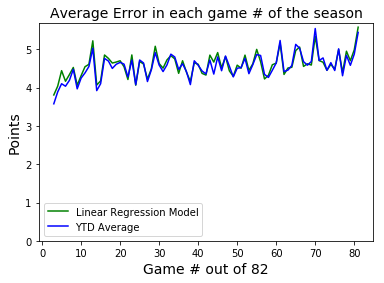

In [25]:
reg_ytd_errors = plt.plot(regressor_dataframe[['GAME_NUMBER', 'REGRESSOR_ERROR']].groupby(['GAME_NUMBER']).mean(), color="green", label="Linear Regression Model")
reg_ytd_errors = plt.plot(regressor_dataframe[['GAME_NUMBER', 'YTD_ERROR']].groupby(['GAME_NUMBER']).mean(), color="blue", label="YTD Average")
reg_ytd_errors = plt.legend()
reg_ytd_errors = plt.xlabel('Game # out of 82', fontsize=14)
reg_ytd_errors = plt.ylabel('Points', fontsize=14)
reg_ytd_errors = plt.title('Average Error in each game # of the season', fontsize=14)
reg_ytd_errors = plt.ylim(ymin=0)

<p>We can see here that our linear regression model follows very similar average error for each game # of the season. This is a promising sign! Let's take a look at how the points predicted stacks up against each other.</p>

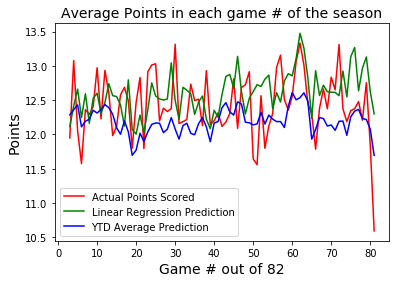

In [26]:
reg_ytd_pts = plt.plot(regressor_dataframe[['GAME_NUMBER', 'PTS']].groupby(['GAME_NUMBER']).mean(), color="red", label="Actual Points Scored")
reg_ytd_pts = plt.plot(regressor_dataframe[['GAME_NUMBER', 'REGRESSION_PRED']].groupby(['GAME_NUMBER']).mean(), color="green", label="Linear Regression Prediction")
reg_ytd_pts = plt.plot(regressor_dataframe[['GAME_NUMBER', 'PTS_YTD']].groupby(['GAME_NUMBER']).mean(), color="blue", label="YTD Average Prediction")
reg_ytd_pts = plt.legend()
reg_ytd_pts = plt.xlabel('Game # out of 82', fontsize=14)
reg_ytd_pts = plt.ylabel('Points', fontsize=14)
reg_ytd_pts = plt.title('Average Points in each game # of the season', fontsize=14)

<p>The graph is a little bit hard to visualize given the different colors overlapping. This is however crucial. Interestingly, our linear regression model did catch the big spike in points scored at around 60 games. Our model did not do a good job at around game 50.</p>

<p>Overall, our linear regression model seems to be predicting higher results than what is actually scored on average. I believe this may be due to the fact that we are feeding in players into our machine learning model who score higher points than average. For example, Kevin Durant, Stephen Curry, James Harden, etc. all score on average, above 20 points per game. However, we want our machine learning algorithm to handle for these players as well since they are usually the most important players in your fantasy team. We never theless have to include them in our model (or at the very least, handle them in a seperate linear regression model). We have tried to classify these players as "starters" for players who are more likely to score these high points by accounting for players who start and by using the minutes played variable for players who play significant minutes. Never the less, this does lead us to our next data point to explore.</p>

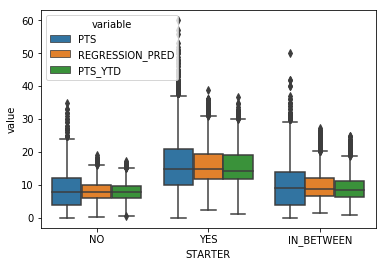

In [27]:
starters_boxplot = pd.melt(regressor_dataframe[['STARTER', 'PTS','REGRESSION_PRED', 'PTS_YTD']],id_vars=['STARTER'], value_vars=['PTS','REGRESSION_PRED','PTS_YTD'])
axs = sns.boxplot(x="STARTER",y="value", data=starters_boxplot, hue = 'variable')

<p>We can see from this model, that from our data, that our regression model doesn't handle the outliers quite well for the starter position. There are still quite a few outliers here. We will need to take a look further and see how we can flag these players for our model.</p>

<p>Given we know this, we might need to create two linear regression models to handle for this misrepresentation in data. One model to handle for all-star players and anohter model to handle for all other players.</p>

<h3>4. Fitting our data into the Random Forest Regressor Model</h3>

In [28]:
#import RandomForest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state = 42)

<p>Ideally for this project, we would have more time for our project run a random grid search. However, given we have a time constraint, we will not be able to do this. Rather instead, we will do a gridsearch on a few hyperparameters to show what needs to be done.</p>
<p><b>NOTE:</b> The below code will not be ran. We will run this later to improve the model.</p>

In [16]:
#NOT RAN
# Number of trees in random forest
n_estimators = [500,1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 25, 50]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [500, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 25, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [ ]:
rf_random.best_params_

<h3>5. Cross Validate our Random Forest Regressor and optimize</h3>

<p>Two key components in machine learning is to always cross-validate and to always choose our hyperparameters correctly. Forunately for us, GridSearchCV does this for us! We will be completting the following:</p>

<p>
1. Feed GridSearchCV a list of hyperparameters are both relatively large and relatively small.<br>
2. We will perform a 3-fold cross validation by specifying the cv to be 3 in our GridSearchCV function to ensure that we are not overfitting our model to the training data.<br>
3. We will then print the results of the best parameters from the GridSearchCV. We will take a look at the mean absolute score. And perform another iteration of these steps with another list of hyperparameters that is either larger or smaller depending on our results.</p>

<p>Ideally, we would not be doing step 3, and would rather be feeding GridSearchCV a larger list of the hyperparameters. However, we will be sacrificing precious time which we do not have in completing this capstone project.</p>

In [31]:
from sklearn.model_selection import GridSearchCV
param_grid = {'bootstrap': [True],
 'max_depth': [10, 20],
 'max_features': [2, 10],
 'min_samples_leaf': [3],
 'min_samples_split': [8],
 'n_estimators': [500, 2000]}
#{
#    'bootstrap': [True],
#    'max_depth': [80],
#    'max_features': [2],
#    'min_samples_leaf': [3],
#    'min_samples_split': [8],
#    'n_estimators': [100, 500, 1000]
#}

In [32]:
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:  7.4min remaining:   40.5s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  7.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [10, 100], 'max_features': [2, 10], 'min_samples_leaf': [3], 'min_samples_split': [8], 'n_estimators': [500, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [33]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 2000}

In [35]:
best_grid = grid_search.best_estimator_

In [36]:
predictions = best_grid.predict(X_test)
errors = abs(predictions - y_test['PTS'].values)

In [37]:
mean_error = np.mean(errors)
mean_error

4.6305317280105855

<p>We can see that our first iteration did not perform as well as the linear regression. Let's see if we can do better.</p>

In [38]:
param_grid_2 = {'bootstrap': [True],
 'max_depth': [100, 150],
 'max_features': [10, 20],
 'min_samples_leaf': [3, 5],
 'min_samples_split': [8, 16],
 'n_estimators': [2000,2500]}

In [ ]:
rf_2 = RandomForestRegressor()
# Instantiate the grid search model
grid_search_2 = GridSearchCV(estimator = rf_2, param_grid = param_grid_2, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search_2.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 25.7min


<h3>6. Compare our Linear Regression Model with the Random Forest Regressor</h3>

In [56]:
regressor_pred = regressor.predict(X_test)
regressor_error = abs(regressor_pred - y_test['PTS'].values)

In [57]:
mean_regressor_error = np.mean(regressor_error)
mean_regressor_error 

7.596518137238636

<h3>7. Compare our optimal machine learning algorithm with the Y-T-D average</h3>

In [81]:
ytd_error = abs(YTD_test - y_test['PTS'].values)
mean_ytd_error = np.mean(ytd_error)
mean_ytd_error

4.783216971715962

<h3>8. Conclusion and Next Steps</h3>

<p>Now based on these steps, we can take a few further steps to improve our model:
<br> 1. Under our linear regression model, our data is being skewed by all-star players. Thus our model is being overinflated. As such, we may need two models - one for players who's average minutes played is above a certain threshold. Given the Warriors have 4 all-stars who average above 20+ points a game. We will use Steph Curry's average of 32 minutes per game as the cut off for these players to analyze in our final report.
<br> 2. Another variable we notice that might be overfitting our data to the training set due to the 29 teams variable. I believe that our models are not performing as well because our data is training over the datasets for past years and does not take into account big off-season moves. For example, this past season for our test set, we saw Carmelo Anthony and Paul George being moved to OKC Thunder. Three teams would have changed up the PACE of their game vs the past seasons. This may be causing our data to not account for this. So instead of our data being trained on each specific team that the player is playing against, we will only take into account for that specific team's PACE of game, Offensive Rating and Defensive Rating. This way our machine learning algorithm will not overfit and should much more accurately predict out the points. We will complete this in our final report as well.
</p>